In [18]:
import numpy as np
import xarray as xr
import re
from pathlib import Path
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.font_manager as fm
import seaborn as sns
sns.set_style("dark")
from utils import *

In [19]:
# CONFIGURE SCRIPT
# Where to find Alchemist data files
directory = '../data'
# Where to save charts
output_directory = 'custom-charts'
# How to name the summary of the processed data
pickleOutput = 'data_summary'
# Experiment prefixes: one per experiment (root of the file name)
experiments = ['export']
floatPrecision = '{: 0.3f}'
# Number of time samples 
timeSamples = 80
# time management
minTime = 60
maxTime = 12 * 3600
timeColumnName = 'time'
logarithmicTime = False
# One or more variables are considered random and "flattened"
seedVars = ['seed']
# Label mapping


In [20]:
if os.path.exists(directory):
    newestFileTime = max([os.path.getmtime(directory + '/' + file) for file in os.listdir(directory)], default=0.0)
    try:
        lastTimeProcessed = pickle.load(open('timeprocessed', 'rb'))
    except:
        lastTimeProcessed = -1
    shouldRecompute = not os.path.exists(".skip_data_process") and newestFileTime != lastTimeProcessed
    if not shouldRecompute:
        try:
            means = pickle.load(open(pickleOutput + '_mean', 'rb'))
            stdevs = pickle.load(open(pickleOutput + '_std', 'rb'))
        except:
            shouldRecompute = True
    if shouldRecompute:
        timefun = np.logspace if logarithmicTime else np.linspace
        means = {}
        stdevs = {}
        for experiment in experiments:
            # Collect all files for the experiment of interest
            import fnmatch
            allfiles = filter(lambda file: fnmatch.fnmatch(file, experiment + '_*.csv'), os.listdir(directory))
            allfiles = [directory + '/' + name for name in allfiles]
            allfiles.sort()
            # From the file name, extract the independent variables
            dimensions = {}
            for file in allfiles:
                dimensions = mergeDicts(dimensions, extractCoordinates(file))
            dimensions = {k: sorted(v) for k, v in dimensions.items()}
            # Add time to the independent variables
            dimensions[timeColumnName] = range(0, timeSamples)
            # Compute the matrix shape
            shape = tuple(len(v) for k, v in dimensions.items())
            # Prepare the Dataset
            dataset = xr.Dataset()
            for k, v in dimensions.items():
                dataset.coords[k] = v
            if len(allfiles) == 0:
                print("WARNING: No data for experiment " + experiment)
                means[experiment] = dataset
                stdevs[experiment] = xr.Dataset()
            else:
                varNames = extractVariableNames(allfiles[0])
                for v in varNames:
                    if v != timeColumnName:
                        novals = np.ndarray(shape)
                        novals.fill(float('nan'))
                        dataset[v] = (dimensions.keys(), novals)
                # Compute maximum and minimum time, create the resample
                timeColumn = varNames.index(timeColumnName)
                allData = { file: np.matrix(openCsv(file)) for file in allfiles }
                computeMin = minTime is None
                computeMax = maxTime is None
                if computeMax:
                    maxTime = float('-inf')
                    for data in allData.values():
                        maxTime = max(maxTime, data[-1, timeColumn])
                if computeMin:
                    minTime = float('inf')
                    for data in allData.values():
                        minTime = min(minTime, data[0, timeColumn])
                timeline = timefun(minTime, maxTime, timeSamples)
                # Resample
                for file in allData:
#                    print(file)
                    allData[file] = convert(timeColumn, timeline, allData[file])
                # Populate the dataset
                for file, data in allData.items():
                    dataset[timeColumnName] = timeline
                    for idx, v in enumerate(varNames):
                        if v != timeColumnName:
                            darray = dataset[v]
                            experimentVars = extractCoordinates(file)
                            darray.loc[experimentVars] = data[:, idx].A1
                # Fold the dataset along the seed variables, producing the mean and stdev datasets
                mergingVariables = [seed for seed in seedVars if seed in dataset.coords]
                means[experiment] = dataset.mean(dim = mergingVariables, skipna=True)
                stdevs[experiment] = dataset.std(dim = mergingVariables, skipna=True)
        # Save the datasets
        pickle.dump(means, open(pickleOutput + '_mean', 'wb'), protocol=-1)
        pickle.dump(stdevs, open(pickleOutput + '_std', 'wb'), protocol=-1)
        pickle.dump(newestFileTime, open('timeprocessed', 'wb'))
else:
    means = { experiment: xr.Dataset() for experiment in experiments }
    stdevs = { experiment: xr.Dataset() for experiment in experiments }
    
for experiment in experiments:
    current_experiment_means = means[experiment]
    current_experiment_errors = stdevs[experiment]

In [21]:
consumptions = current_experiment_means[
    { 'batteryConsumption[sum]', 'cloudConsumption[sum]', 'totalConsumption[sum]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

instances = current_experiment_means[
    { 'instances' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

charging = current_experiment_means[
    { 'isCharging[sum]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

batteryPercentage = current_experiment_means[
    { 'batteryPercentage[mean]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

distance = current_experiment_means[
    { 'distance[mean]' }
].mean(dim = { 'epi_ratio', 'device_count', 'cloud_epi', 'battery_discharge_time' }, skipna = True)

In [23]:
consumptions_mean = consumptions.mean(dim = { 'time' }, skipna = True)
consumption_df = consumptions_mean.to_dataframe()
consumption_df

,batteryConsumption[sum],totalConsumption[sum],cloudConsumption[sum]
balance,,,
"[0, 100]",1253.932333,1253.935083,0.000000
"[101, 101]",804.861500,19780.088313,18975.193403
"[20, 60]",1118.957542,7434.413910,6315.413710
"[20, 80]",1062.587417,9255.708410,8193.293007
"[40, 60]",982.416799,11991.237285,11008.890479
"[40, 80]",950.304333,13028.936931,12078.631465


In [11]:
charging_sum = charging.sum(dim = { 'time' }, skipna = True)
charging_df = charging_sum.to_dataframe().tail(-1)
charging_df

,isCharging[sum]
balance,
"[101, 101]",3782.000000
"[20, 60]",5430.000000
"[20, 80]",5275.000000
"[40, 60]",4996.833333
"[40, 80]",4883.000000


In [13]:
distance_mean = distance.mean(dim = { 'time' }, skipna = True)
distance_df = distance_mean.to_dataframe().tail(-1)
distance_df

distance[mean]
high_battery_threshold low_battery_threshold                
70.0                   30.0                        24.007617
100.0                  0.0                         21.972354
                       30.0                        24.684812

<Axes: xlabel='high_battery_threshold,low_battery_threshold'>

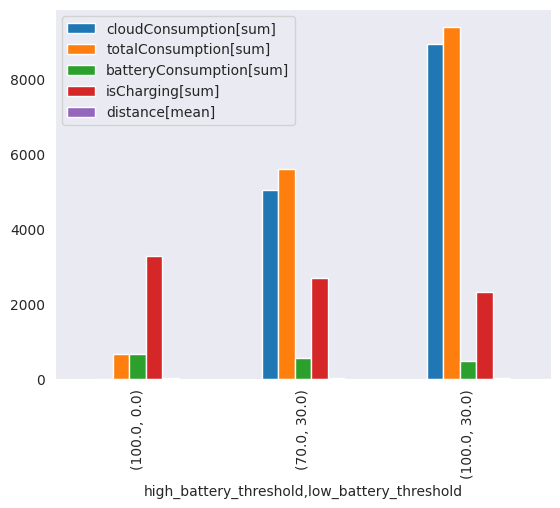

In [101]:
import pandas as pd
result = pd.concat([consumption_df, charging_df, distance_df], axis=1, join='inner')
result = result.sort_values(by=['totalConsumption[sum]'])
result.plot.bar()

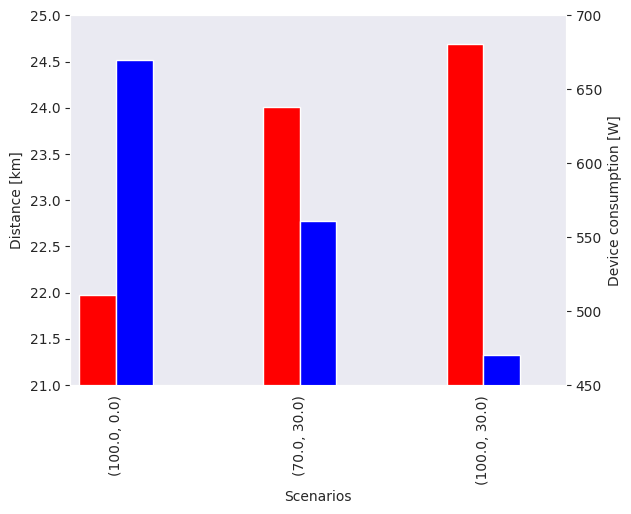

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

merged = pd.concat([distance_df, consumption_df], axis=1, join='inner')
merged = merged.sort_values(by=['totalConsumption[sum]'])

width = 0.2
merged['distance[mean]'].plot.bar(ax=ax, color='red', width=width, position=1)
merged['batteryConsumption[sum]'].plot.bar(ax=ax2, color='blue', width=width, position=0)

ax.set_ylabel('Distance [km]')
ax.set_xlabel('Scenarios')
ax.set_ylim([21, 25])
ax2.set_ylim([450, 700])
ax2.set_ylabel('Device consumption [W]')
plt.show()

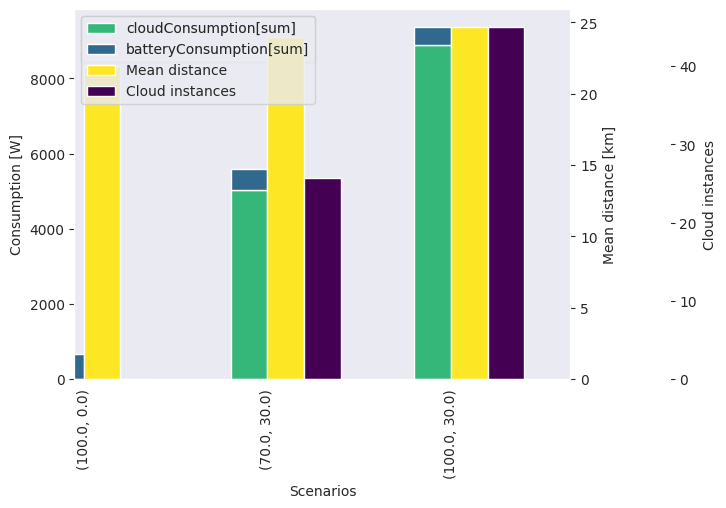

In [147]:
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines.right.set_position(("axes", 1.2))

instances_df = instances.mean(dim={'time'}, skipna=True).to_dataframe().tail(-1)

merged = pd.concat([distance_df, consumption_df, charging_df, instances_df], axis=1, join='inner')
merged = merged.sort_values(by=['totalConsumption[sum]'])

width = 0.2
merged[['cloudConsumption[sum]','batteryConsumption[sum]']].plot.bar(ax=ax, color=['#35b779', '#31688e'], width=width, position=1, stacked=True, label={'Cloud consumption', 'Device consumption'})
merged['distance[mean]'].plot.bar(ax=ax2, color='#fde725', width=width, position=0, label='Mean distance')
merged['instances'].plot.bar(ax=ax3, color='#440154', width=width, position=-1, label='Cloud instances')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

ax.set_ylabel('Consumption [W]')
ax.set_xlabel('Scenarios')
#ax.set_ylim([4000, 10000])

ax2.set_ylabel('Mean distance [km]')
#ax2.set_ylim([21, 25])

ax3.set_ylabel('Cloud instances')

plt.show()

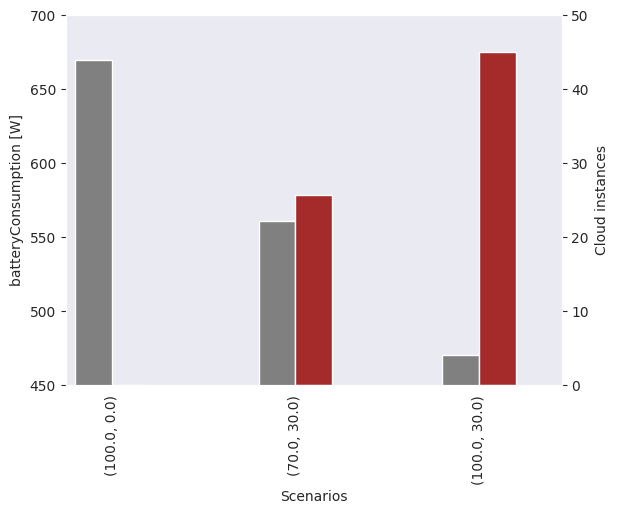

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

instances_sum = instances.mean(dim = { 'time' }, skipna = True)
instances_df = instances_sum.to_dataframe().tail(-1)

merged = pd.concat([distance_df, consumption_df, instances_df], axis=1, join='inner')
merged = merged.sort_values(by=['totalConsumption[sum]'])

width = 0.2
merged['batteryConsumption[sum]'].plot.bar(ax=ax, color='gray', width=width, position=1)
merged['instances'].plot.bar(ax=ax2, color='brown', width=width, position=0)

ax.set_ylabel('batteryConsumption [W]')
ax.set_xlabel('Scenarios')
ax.set_ylim([450, 700])
ax2.set_ylim([0, 50])
ax2.set_ylabel('Cloud instances')
plt.show()